## Transcription factor feature importance
- TF-IDF
- Gini importance
- Recursive feature elimination
- Lasso regression
    - https://towardsdatascience.com/feature-selection-in-machine-learning-using-lasso-regression-7809c7c2771a
- SHAP
    - https://github.com/slundberg/shap
- RFC classifier
- PCA

Test percentual position of TFs and absolute position

TODO  normalize the number of occurences of a motif using its pwm log odds


In [3]:
import pickle
import Bio.SeqIO as SeqIO
# Load Transcription factor binary files
LTR_TF_sites = pickle.load(open("/storage/brno2/home/xhorvat9/Diplomovka_DBs/JASPAR_Profiles/sequence_motifs.b", "rb"))

non_LTR_TF_sites = {}
for i in range(4):
    d = pickle.load(open(f"/storage/brno2/home/xhorvat9/ltr-annotator/Diplomovka_Final/JASPAR_work/non_LTR_sequence_motifs{i}.b", "rb"))
    for seq in d:
        non_LTR_TF_sites[seq] = d[seq]

In [8]:
print("Non-LTR count:",len(list(non_LTR_TF_sites.keys())), "\nLTR count:", len(list(LTR_TF_sites.keys())))

Non-LTR count: 43972 
LTR count: 85418


In [15]:
# Need to extract only those LTR sequences that are present in 
LTR_TF_sites = dict([(record.id, LTR_TF_sites[record.id]) for record in SeqIO.parse("/storage/brno2/home/xhorvat9/ltr-annotator/Diplomovka_Final/1_Database_build/Positive_train_sequences/representative_LTRs.fasta", "fasta") if record.id in LTR_TF_sites])

In [18]:
list(non_LTR_TF_sites.keys())[0]

'0_non-LTR_generated'

In [20]:
# Convert to presence/count dictionary to make it easier to work with 
def get_presence_count_dict(motif_dict_count, motif_dict_presence, TF_sites):
    for seq in TF_sites:
        for motif in motif_dict_count:
            if len(TF_sites[seq][motif]) > 0:
                motif_dict_count[motif].append(len(TF_sites[seq][motif]))
                motif_dict_presence[motif].append(1)
            else:
                motif_dict_count[motif].append(0)
                motif_dict_presence[motif].append(0)

LTR_motif_dict_count = dict([(key, []) for key in LTR_TF_sites["ID=RLC_100_1_Gr"]])
LTR_motif_dict_presence = dict([(key, []) for key in LTR_TF_sites["ID=RLC_100_1_Gr"]])
get_presence_count_dict(LTR_motif_dict_count, LTR_motif_dict_presence, LTR_TF_sites)


non_LTR_motif_dict_count = dict([(key, []) for key in non_LTR_TF_sites['0_non-LTR_generated']])
non_LTR_motif_dict_presence = dict([(key, []) for key in non_LTR_TF_sites['0_non-LTR_generated']])
get_presence_count_dict(non_LTR_motif_dict_count, non_LTR_motif_dict_presence, non_LTR_TF_sites)

In [22]:
import pandas as pd
LTR_motif_count = pd.DataFrame(LTR_motif_dict_count)
nonLTR_motif_count = pd.DataFrame(non_LTR_motif_dict_count)
all_motifs = pd.concat([LTR_motif_count, nonLTR_motif_count])

#### Testing TF-IDF

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
tfidf_transformed_data = transformer.fit_transform(all_motifs)

In [24]:
print(tfidf_transformed_data.todense())

[[0.02957867 0.02848415 0.00886283 ... 0.04039066 0.08067668 0.02710892]
 [0.02639881 0.01255721 0.01730318 ... 0.04576463 0.06157118 0.018902  ]
 [0.02054208 0.01889838 0.00621432 ... 0.06001271 0.03565488 0.04127426]
 ...
 [0.04727664 0.         0.         ... 0.04034863 0.         0.        ]
 [0.07466491 0.         0.         ... 0.         0.         0.        ]
 [0.11629778 0.0632226  0.         ... 0.04962764 0.         0.        ]]


#### Select K best

Text(0.5, 0, 'TFBS motif name')

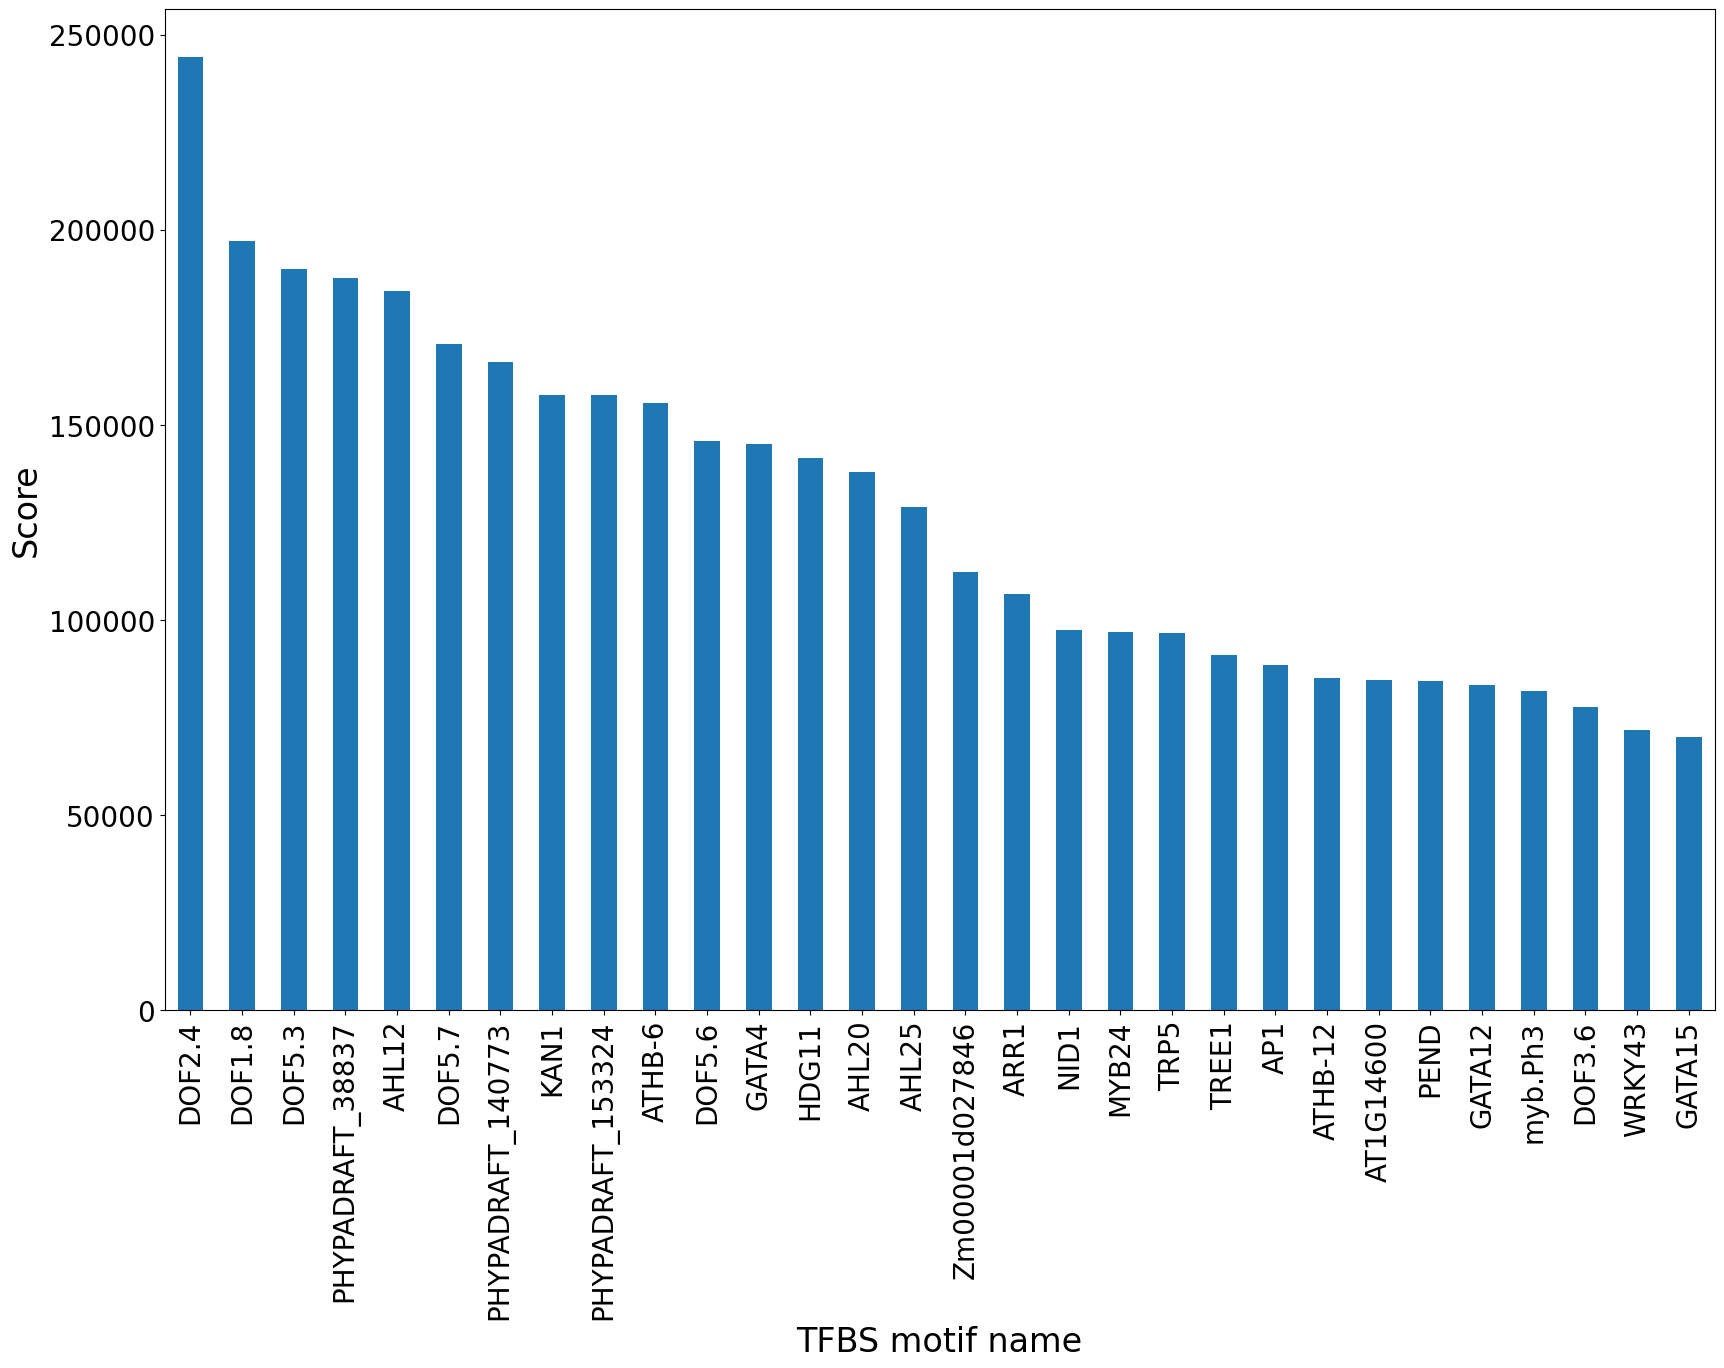

In [47]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

labels = [1]*len(LTR_motif_count) + [0]*len(nonLTR_motif_count)

# Feature selection
bestfeatures = SelectKBest(score_func=chi2, k=150)
fit = bestfeatures.fit(all_motifs,labels)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(all_motifs.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['TFBS','Score']  #naming the dataframe columns
#print(featureScores.nlargest(30,'Score'))  #print 10 best features
ax = featureScores.nlargest(30,'Score').plot.bar(x="TFBS", y="Score", figsize=(20, 13), fontsize=20, legend=False)
ax.set_ylabel('Score',fontdict={'fontsize':24})
ax.set_xlabel('TFBS motif name',fontdict={'fontsize':24})

#### PCA
- Compare PCA using all TFs versus PCA using selected n best features

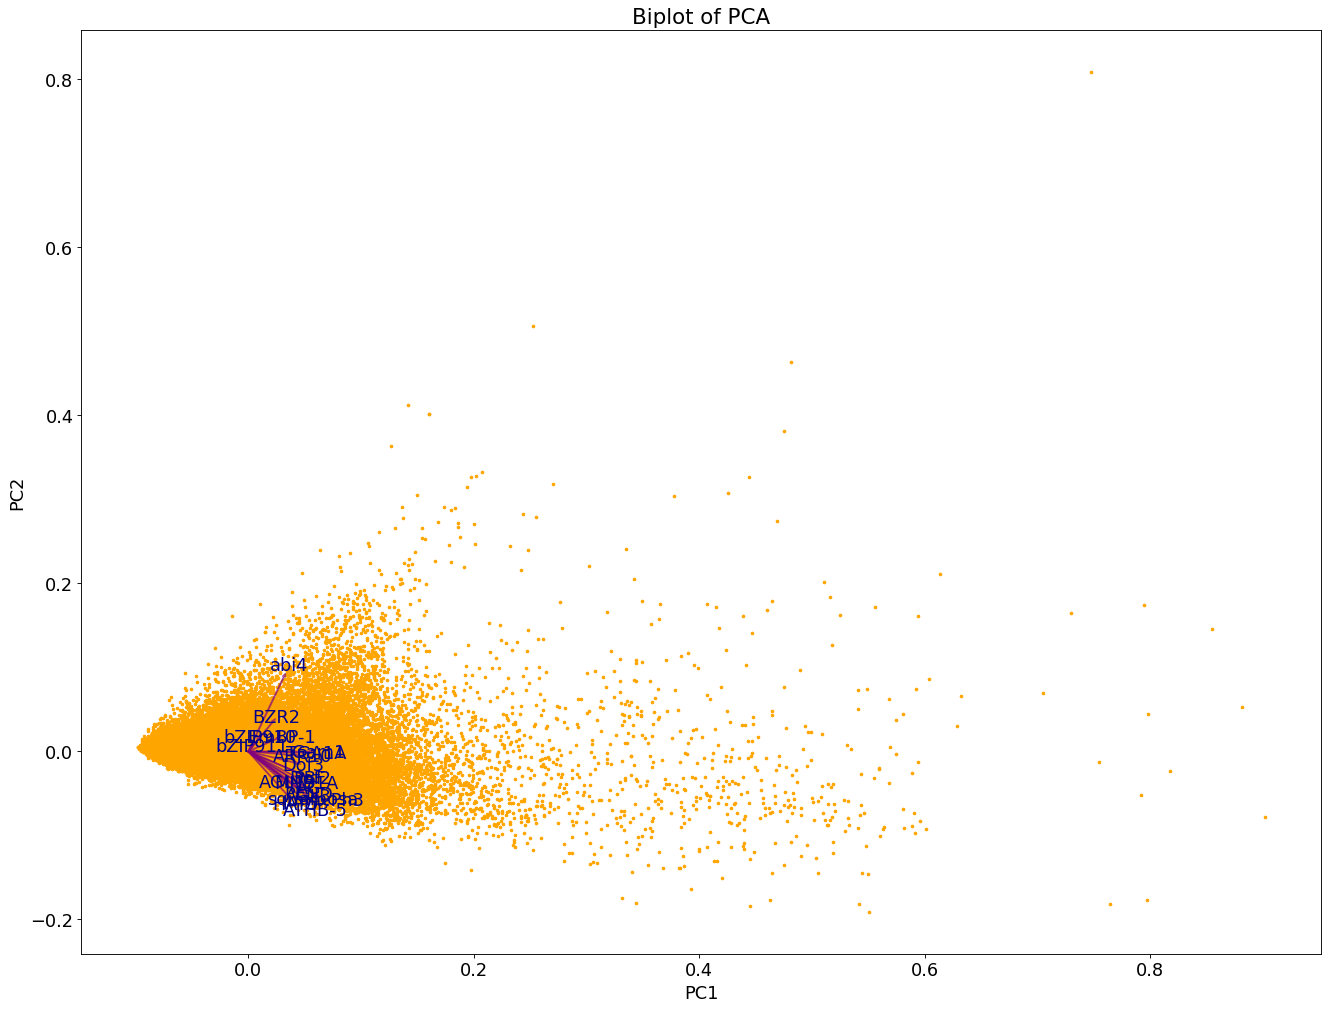

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def biplot(score,coef,labels=None):
    """
    Code from https://statisticsglobe.com/biplot-pca-python
    
    """
    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,
                s=5, 
                color='orange')
 
    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'purple',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'darkblue', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
 

scaler = StandardScaler()
 
scaler.fit(LTR_motif_count)
 
Diabetes_scaled = scaler.transform(LTR_motif_count)


pca = PCA(n_components=7)
PC = pca.fit_transform(Diabetes_scaled)
pca_diabetes = pd.DataFrame(data = PC,
               columns = ['PC 1', 'PC 2','PC 3', 'PC 4', 'PC 5','PC 6', 'PC 7'])
 
pca_diabetes.head(6)
plt.figure(figsize=(20, 15), dpi=80)
plt.rcParams.update({'font.size': 16})
plt.title('Biplot of PCA')
 
biplot(PC, 
       np.transpose(pca.components_)[:20], 
       list(LTR_motif_count.columns)[:20])

In [ ]:
from sklearn.decomposition import PCA
from  seaborn import scatterplot
import matplotlib.pyplot as plt

# create and fit the PCA
pca = PCA(n_components=2)
sc= pca.fit_transform(all_motifs)

# plot the data
fig, ax = plt.subplots(figsize=(18, 12))
plot= scatterplot(x=[x[0] for x in sc][:len(all_motifs)//2], y=[x[1] for x in sc][:len(all_motifs)//2], c=['#1f77b4'])
plot.set_title('PCA on the training/test set')

#sc= pca.transform(nonLTR_motif_count)

# plot the data
scatterplot(x=[x[0] for x in sc][len(all_motifs)//2:], y=[x[1] for x in sc][len(all_motifs)//2:],c=["#FF0000"], alpha=0.4)

#### Extra trees classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(all_motifs,labels)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=all_motifs.columns)

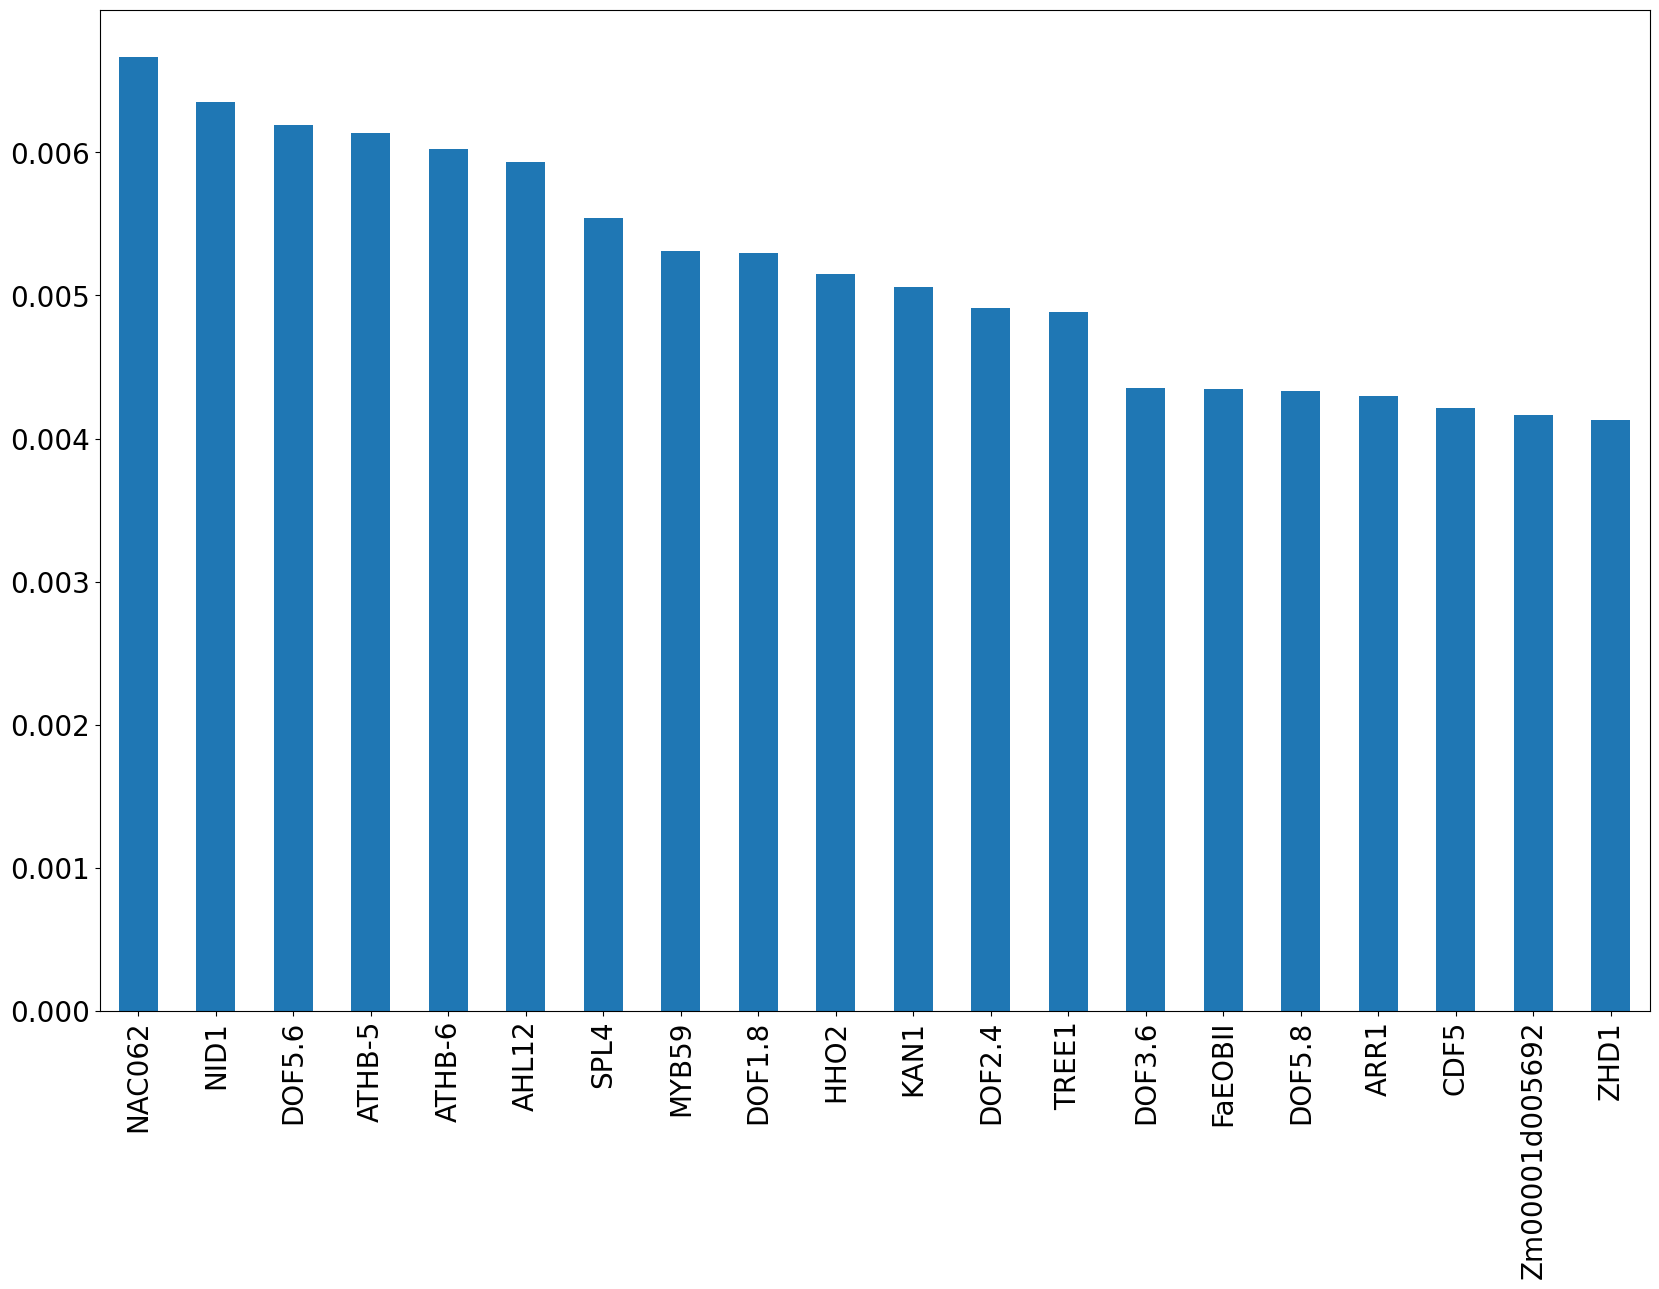

In [82]:
feat_importances.nlargest(20).plot.bar(figsize=(20, 13), fontsize=20, legend=False)
plt.show()

#### Recursive feature elimination

#### Correlogram

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
#get correlations of each features in dataset
data = all_motifs.copy()
data["isLTR"] = labels
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map

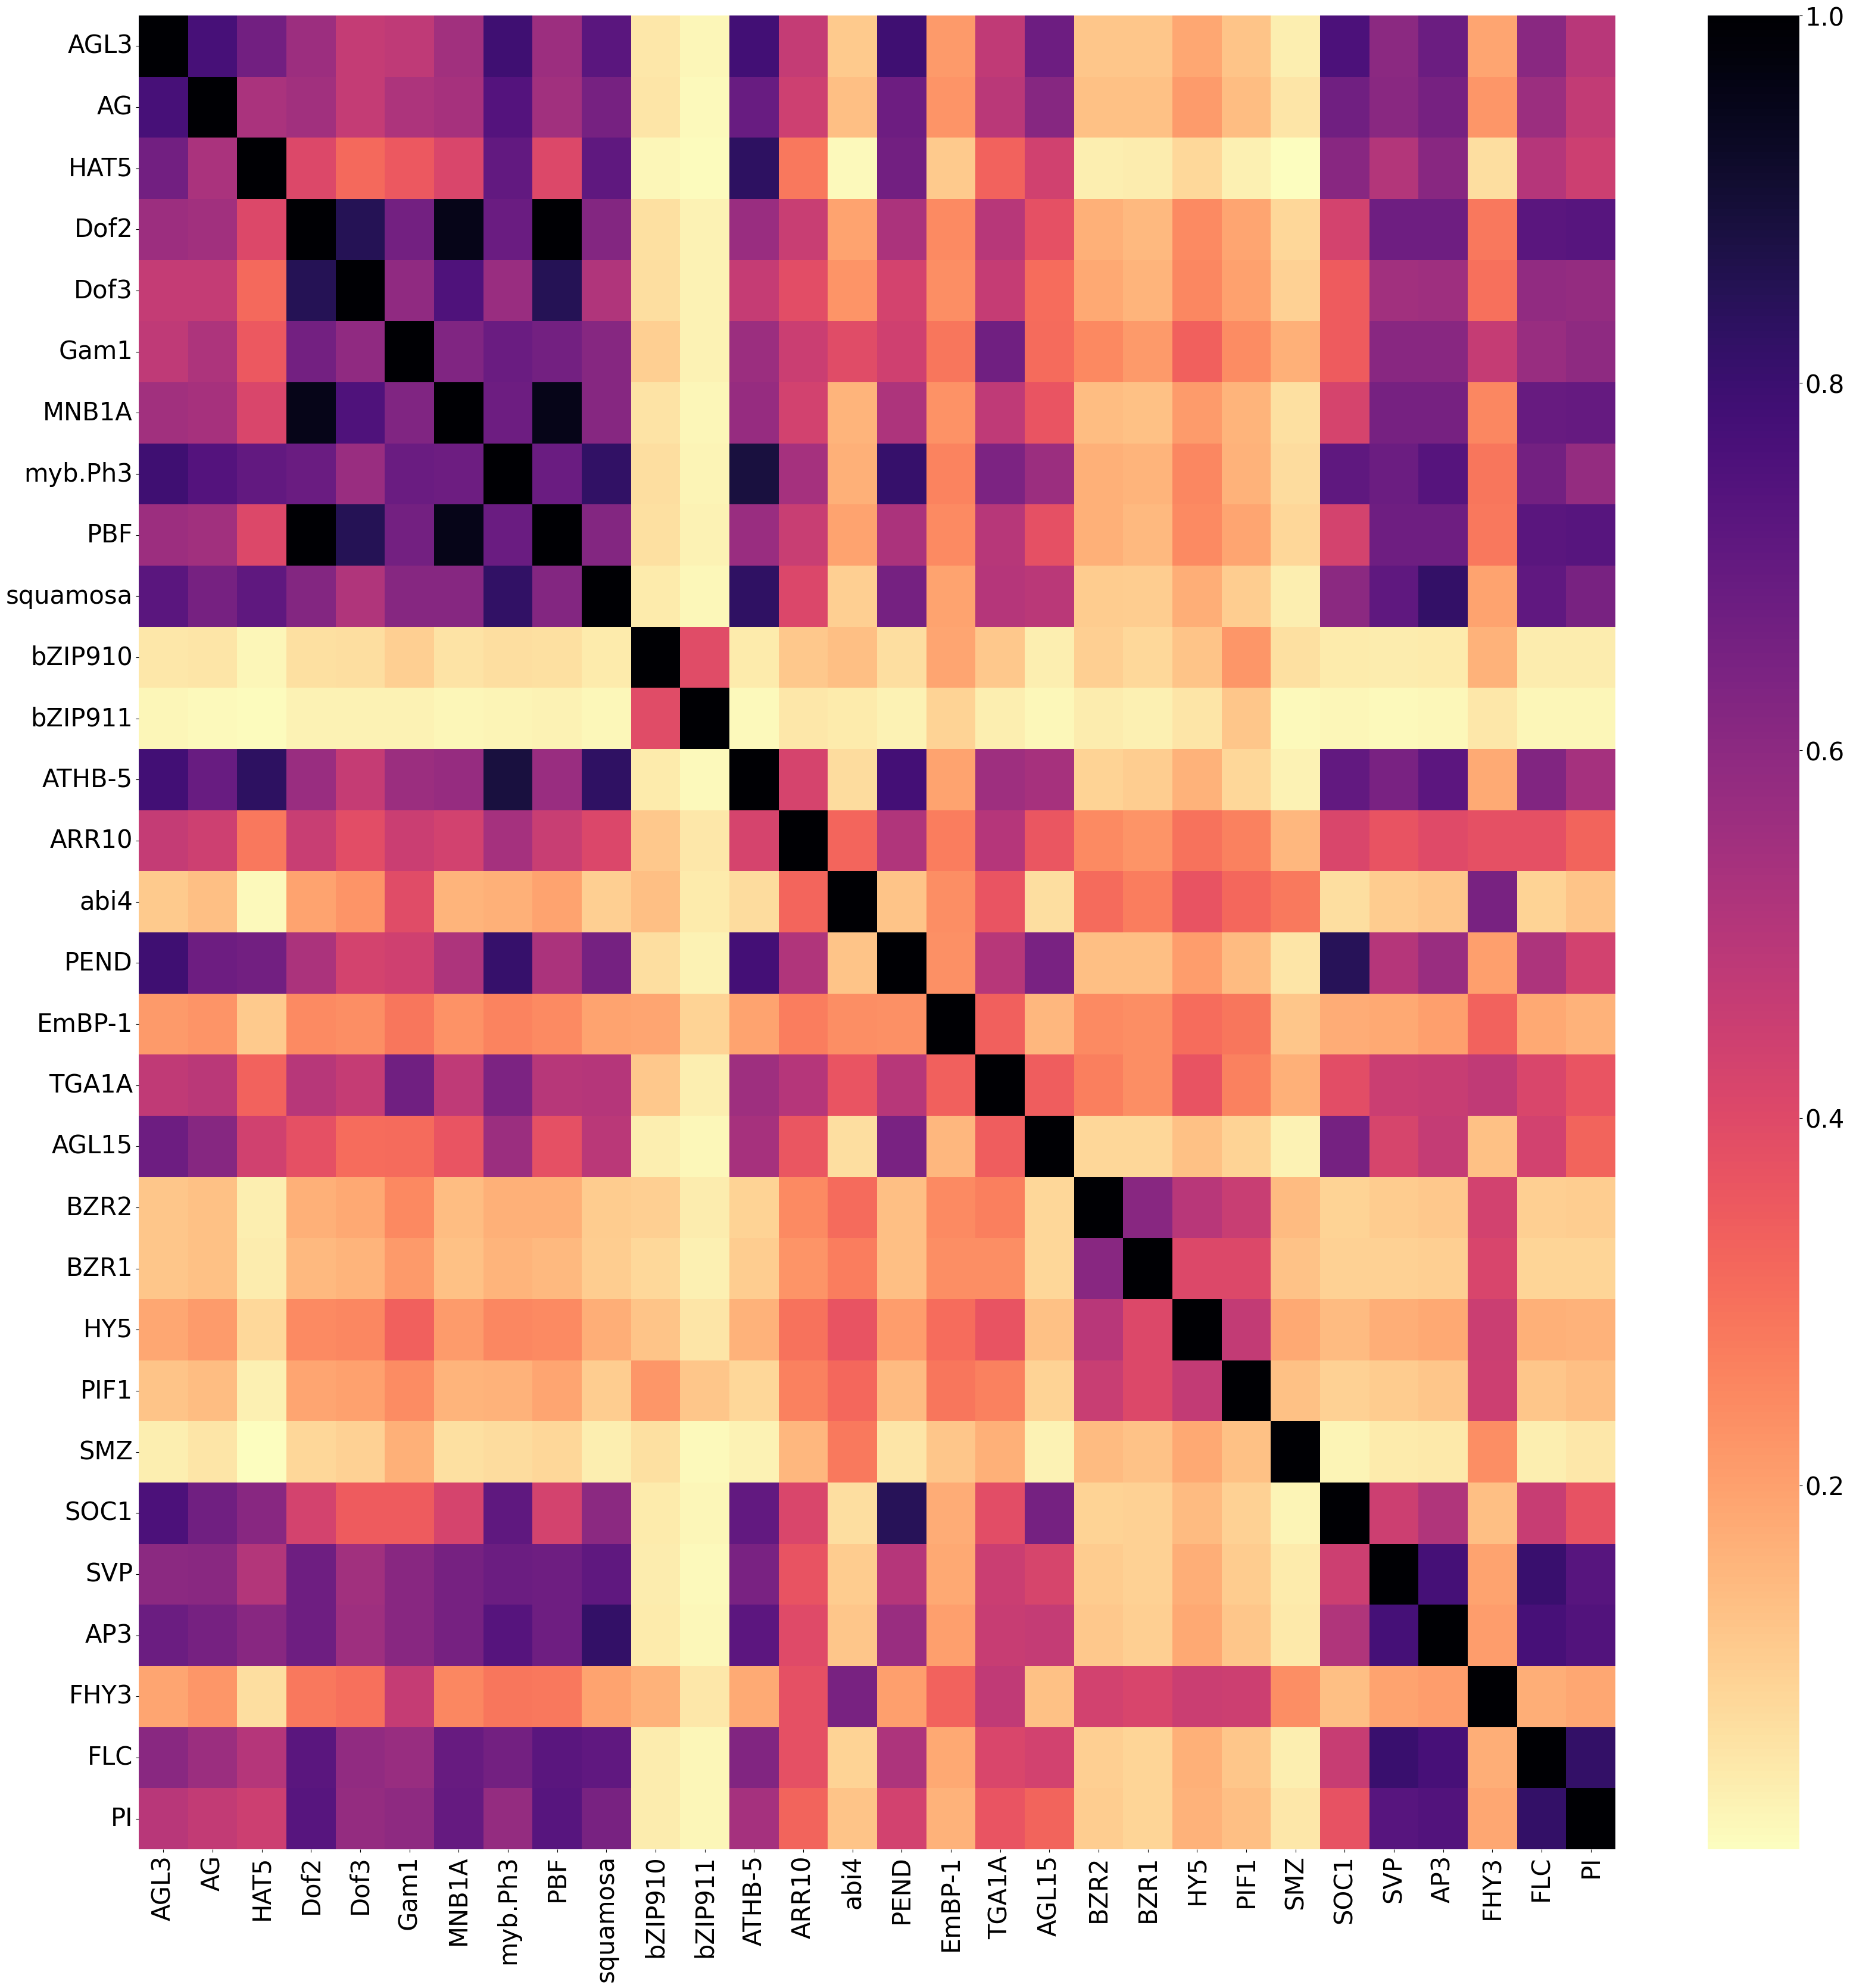

In [102]:
top = top_corr_features[:30]

plt.figure(figsize=(40, 40), dpi=100)

plt.rcParams.update({'font.size': 30})
g=sns.heatmap(data[top].corr(),annot=False,cmap="magma_r")